In [ ]:
import sys
print(sys.version)

3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]


# DL톤 해파리 분류기
아이펠 코어 12기 팀: 해파리지앵  
@author: Hyeseung Lee  
Created: 2025-04-01  

## Introduction

해파리 분류기 노트북 코드 요약 설명
이 노트북 코드는 딥러닝을 사용하여 해파리 이미지를 분류하는 모델을 구축하고 훈련하는 과정을 담고 있습니다. 주요 기능과 단계는 다음과 같습니다.

1. 데이터 준비 및 전처리:

Google Drive에 저장된 해파리 이미지 데이터셋을 불러옵니다. 데이터셋은 훈련, 검증, 테스트셋으로 나뉘어져 있습니다.
load_dataset_from_directory 함수를 사용하여 이미지를 로드하고 크기를 조정합니다.
count_images_per_class 함수를 사용하여 각 클래스별 이미지 개수를 확인하고 데이터 분포를 파악합니다.
get_class_labels 함수를 사용하여 디렉토리 구조를 기반으로 클래스 레이블을 자동으로 추출합니다.
2. 데이터 증강:

AugmentationManager 클래스를 사용하여 훈련 이미지에 대한 데이터 증강 파이프라인을 생성합니다.
회전, 이동, 확대/축소, 수평 뒤집기 등 다양한 증강 기법을 적용하여 모델의 일반화 성능을 향상시킵니다.
apply_augmentation 함수를 사용하여 증강된 이미지를 생성하고 시각화하여 증강 결과를 확인합니다.
gaussian_blur, salt_and_pepper_noise, gaussian_noise 함수를 통해 추가적인 노이즈 증강 기법을 적용할 수 있습니다.
3. 모델 구축 및 훈련:

JellyfishClassifier 클래스를 사용하여 해파리 분류 모델을 정의합니다.
EfficientNet, MobileNet, ResNet 등 다양한 사전 훈련된 모델을 기반으로 모델을 구축할 수 있습니다.
fit 메서드를 사용하여 모델을 훈련합니다. 훈련 과정에서 검증 데이터를 사용하여 모델 성능을 평가하고 조기 종료 및 체크포인트 기능을 활용하여 최적의 모델을 저장합니다.
훈련 중에는 TqdmCallback을 사용하여 진행 상황을 시각적으로 표시합니다.
ReduceLROnPlateau 콜백을 사용하여 검증 손실이 정체될 경우 학습률을 조정합니다.
4. 모델 평가 및 시각화:

evaluate 메서드를 사용하여 테스트 데이터셋에 대한 모델 성능을 평가합니다. 정확도, F1 점수, 엔트로피 등 다양한 지표를 사용하여 모델 성능을 측정합니다.
Test Time Augmentation (TTA) 기법을 적용하여 모델 예측의 정확도를 높일 수 있습니다.
k_fold_cross_validation 메서드를 사용하여 K-fold 교차 검증을 수행하고 모델의 일반화 성능을 평가합니다.
plot_confusion_matrix 함수를 사용하여 혼동 행렬을 시각화하고 모델의 예측 오류를 분석합니다.
plot_training_history 함수를 사용하여 훈련 과정에서의 손실 및 정확도 변화를 시각화합니다.
5. 모델 저장 및 로드:

save_model 메서드를 사용하여 훈련된 모델을 파일로 저장합니다.
load_model 메서드를 사용하여 저장된 모델을 불러와서 사용할 수 있습니다.
6. 예측:

predict 메서드를 사용하여 새로운 이미지에 대한 예측을 수행합니다.
TTA 기법을 적용하여 예측 정확도를 높일 수 있습니다.
요약:

이 노트북 코드는 데이터 준비, 증강, 모델 구축, 훈련, 평가, 시각화, 저장, 로드, 예측 등 딥러닝 모델 개발의 전 과정을 포함하고 있습니다. 다양한 기능과 옵션을 제공하여 사용자가 해파리 이미지 분류 모델을 효과적으로 구축하고 실험할 수 있도록 지원합니다.

# Install libs

In [ ]:
!pip install tqdm

In [ ]:
!pip install opencv-python

In [ ]:
!pip install opencv-python scikit-image

In [ ]:
!pip install scikit-image --upgrade

In [ ]:
!pip install albumentations

## 1. EDA

In [ ]:
from tqdm import tqdm
from tqdm.keras import TqdmCallback
from tqdm.auto import tqdm  # Import tqdm.auto
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from tqdm import tqdm
import warnings
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.utils import Sequence
import math
import random
import glob
import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, callbacks, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import KFold
import cv2
import albumentations as A  # Import Albumentations

### merge from Wongu
import kagglehub
import wandb
from wandb.integration.keras import WandbCallback
from datetime import datetime

# from tensorflow.keras.applications.resnet50 import preprocess_input


warnings.filterwarnings('ignore')

## Common functions

## Prepare Dataset

google drive 의 구조를 맞춰주세요.

원본 이미지 데이터셋 :
/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Train_Test_Valid

클린업 이미지 데이터셋
/content/drive/MyDrive/ColabNotebooks/ToyDatasets/jellyfish-dataset/Clean_dataset/

In [ ]:
#
#
#
def load_dataset_from_directory(directory, img_size=(224, 224), batch_size=32, flatten=False):
    """폴더에서 RGB 이미지 데이터셋을 로드하는 함수 (최신 TensorFlow 방식)"""
    dataset = tf.keras.utils.image_dataset_from_directory(
        directory,
        image_size=img_size,
        batch_size=batch_size,
        color_mode='rgb',
        shuffle=True,
        seed=42,
        labels='inferred',
        label_mode='int'
    )

    # 클래스 이름 가져오기
    class_names = dataset.class_names
    class_dict = {class_name: i for i, class_name in enumerate(class_names)}

    # 데이터셋 전처리 (정규화)
    def preprocess(images, labels):
        images = tf.cast(images, tf.float32) / 255.0
        return images, labels

    dataset = dataset.map(preprocess)

    # 전체 데이터 메모리에 로드
    X_list = []
    y_list = []

    for images, labels in dataset:
        X_list.append(images.numpy())
        y_list.append(labels.numpy())

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)

    # 필요한 경우 평탄화(flatten)
    if flatten:
        X = X.reshape(X.shape[0], -1)  # (n_samples, height*width*channels)

    # 그레이스케일 특화 코드
    # 기존: elif color_mode == 'grayscale': X = X[..., 0]

    return X, y, class_dict

class AugmentationManager:
    """데이터 증강을 관리하는 클래스

    - 증강 파이프라인(ImageDegenerator객체)를 생성하는 역할
    - 즉, 어떤 증강 방법들을 사용할지 설정(configuration)하는 부분
    - 실제로 이미지에 증강을 적용하지는 않음

    """

    @staticmethod
    def create_train_augmentation(rotation_range=20, width_shift_range=0.2,
                                 height_shift_range=0.2, zoom_range=0.2,
                                 horizontal_flip=True, vertical_flip=False,
                                 fill_mode='nearest'):
        '''
        Train Time Augmentation 설정

        Args:
            rotation_range (int): 회전 각도 범위
            width_shift_range (float): 가로 이동 범위
            height_shift_range (float): 세로 이동 범위
            zoom_range (float): 확대/축소 범위
            horizontal_flip (bool): 수평 뒤집기 적용 여부
            vertical_flip (bool): 수직 뒤집기 적용 여부
            fill_mode (str): 채우기 모드

        Returns:
            ImageDataGenerator: 데이터 증강이 적용된 제너레이터
        '''
        train_datagen = ImageDataGenerator(
            # rescale=1./255,
            rotation_range=rotation_range,
            width_shift_range=width_shift_range,
            height_shift_range=height_shift_range,
            zoom_range=zoom_range,
            horizontal_flip=horizontal_flip,
            vertical_flip=vertical_flip,
            fill_mode=fill_mode
        )

        return train_datagen

    @staticmethod
    def create_test_augmentation(n_augmentations=3):
        '''
        Test Time Augmentation 설정 - 가벼운 변형만 적용

        Args:
            n_augmentations (int): TTA에 사용할 증강 횟수

        Returns:
            list: 데이터 제너레이터 리스트
        '''
        # 기본 제너레이터 (변형 없음)
        base_datagen = ImageDataGenerator(rescale=1./255)

        # 증강 제너레이터들
        tta_datagens = [base_datagen]

        if n_augmentations >= 1:
            # 수평 뒤집기
            tta_datagens.append(ImageDataGenerator(
                rescale=1./255,
                horizontal_flip=True
            ))

        if n_augmentations >= 2:
            # 약간 회전
            tta_datagens.append(ImageDataGenerator(
                rescale=1./255,
                rotation_range=10
            ))

        if n_augmentations >= 3:
            # 약간 확대
            tta_datagens.append(ImageDataGenerator(
                rescale=1./255,
                zoom_range=0.1
            ))

        return tta_datagens[:n_augmentations+1]  # 기본 데이터젠도 포함

def apply_augmentation(image, datagen,
                       num_samples=5,
                       apply_gaussian_blur=True,
                       gaussian_blur_prob=0.5,
                       apply_salt_and_pepper=False,
                       salt_and_pepper_prob=0.15,
                       apply_gaussian_noise=True,
                       gaussian_noise_prob=0.5,
                       gaussian_noise_mean=0.0,
                       gaussian_noise_std=0.05,
                       apply_elastic_transform=True,
                       elastic_transform_prob=0.5,
                       apply_random_crop_resize=True,
                       random_crop_resize_prob=0.5,
                       apply_brightness_adjust=True,
                       brightness_adjust_prob=0.5,
                       apply_contrast_adjust=True,
                       contrast_adjust_prob=0.5,
                       apply_hue_adjust=True,
                       hue_adjust_prob=0.5
                       ):
    """
    이미지에 다양한 증강 기법을 적용합니다.

    Args:
        image: 입력 이미지 (NumPy 배열).
        datagen: ImageDataGenerator 객체.
        num_samples: 생성할 증강 이미지 샘플 수 (기본값: 5).
        apply_gaussian_blur: 가우시안 블러 적용 여부 (기본값: True).
        gaussian_blur_prob: 가우시안 블러 적용 확률 (기본값: 0.5).
        apply_salt_and_pepper: Salt and Pepper 노이즈 적용 여부 (기본값: True).
        salt_and_pepper_prob: Salt and Pepper 노이즈 적용 확률 (기본값: 0.15).
        apply_gaussian_noise: 가우시안 노이즈 적용 여부 (기본값: True).
        gaussian_noise_prob: 가우시안 노이즈 적용 확률 (기본값: 0.5).
        gaussian_noise_mean: 가우시안 노이즈의 평균 (기본값: 0.0).
        gaussian_noise_std: 가우시안 노이즈의 표준 편차 (기본값: 0.05).

        apply_elastic_transform: 탄력적 변형 적용 여부 (기본값: True).
        elastic_transform_prob: 탄력적 변형 적용 확률 (기본값: 0.5).
        apply_random_crop_resize: 랜덤 Cropping & Resizing 적용 여부 (기본값: True).
        random_crop_resize_prob: 랜덤 Cropping & Resizing 적용 확률 (기본값: 0.5).
        apply_brightness_adjust: 밝기 조절 적용 여부 (기본값: True).
        brightness_adjust_prob: 밝기 조절 적용 확률 (기본값: 0.5).
        apply_contrast_adjust: 대비 조절 적용 여부 (기본값: True).
        contrast_adjust_prob: 대비 조절 적용 확률 (기본값: 0.5).
        apply_hue_adjust: 색조 조절 적용 여부 (기본값: True).
        hue_adjust_prob: 색조 조절 적용 확률 (기본값: 0.5).

    Returns:
        증강된 이미지 리스트.
    """
    # 이미지 데이터 타입 확인 및 정규화 (필요한 경우),
    if image.dtype == np.uint8:
        image = image.astype(np.float32) / 255.0

    # 이미지 차원 확인 및 처리
    if len(image.shape) == 2:  # 흑백 이미지면
        image = np.expand_dims(image, axis=-1)

    # 배치 차원 추가
    image_batch = np.expand_dims(image, axis=0)

    # 증강 이미지 생성
    augmented_images = []
    for _ in range(num_samples):
        aug_generator = datagen.flow(image_batch, batch_size=1)
        aug_image = next(aug_generator)[0]

        # 차원 처리 (원본 이미지와 동일한 차원으로)
        if len(image.shape) == 3 and len(aug_image.shape) == 4:  # 컬러 이미지 처리
            aug_image = aug_image[:, :, :, 0]  # 채널 차원 제거
        elif len(image.shape) == 2 and len(aug_image.shape) == 3: # 흑백 이미지 처리
            aug_image = aug_image[:, :, 0]  # 채널 차원 제거

        # Gaussian Blur 적용 선택적 적용
        if apply_gaussian_blur and random.random() < gaussian_blur_prob:    # 값이 0.5 면 이미지의 50%에만 확률적 적용
            aug_image = gaussian_blur(aug_image)

        # Salt and Pepper 노이즈 선택적 적용
        if apply_salt_and_pepper and random.random() < salt_and_pepper_prob: # 값이 0.05 면 이미지의 5%만 적용
            aug_image = salt_and_pepper_noise(aug_image)

        # Apply Gaussian Noise with probability and clip
        if apply_gaussian_noise and random.random() < gaussian_noise_prob:
            aug_image = gaussian_noise(aug_image, gaussian_noise_mean, gaussian_noise_std)

        # 탄력적 변형 적용 (Albumentations 사용) and clip
        if apply_elastic_transform and random.random() < elastic_transform_prob:
            transform = A.ElasticTransform(p=1, alpha=random.uniform(30, 70), sigma=random.uniform(4, 6),
                                          alpha_affine=random.uniform(0, 10),
                                          border_mode=cv2.BORDER_REFLECT_101)
            aug_image = transform(image=aug_image)['image']
            aug_image = np.clip(aug_image, 0.0, 1.0)  # Clip after elastic transform

        # 랜덤 Cropping & Resizing 적용
        if apply_random_crop_resize and random.random() < random_crop_resize_prob:
            # 랜덤으로 자를 영역 크기 결정 (원본 이미지의 70%~100% 크기)
            crop_size = random.randint(int(aug_image.shape[0] * 0.7), aug_image.shape[0])
            # 랜덤으로 자를 시작 위치 결정
            crop_x = random.randint(0, aug_image.shape[0] - crop_size)
            crop_y = random.randint(0, aug_image.shape[1] - crop_size)
            # 이미지 자르기
            cropped_image = aug_image[crop_x:crop_x + crop_size, crop_y:crop_y + crop_size]
            # 원본 크기로 리사이징
            aug_image = cv2.resize(cropped_image, (aug_image.shape[0], aug_image.shape[1]))

        # 밝기 조절 적용
        if apply_brightness_adjust and random.random() < brightness_adjust_prob:
            aug_image = tf.image.adjust_brightness(aug_image, delta=random.uniform(-0.2, 0.2))  # 밝기 랜덤 조절
            aug_image = tf.clip_by_value(aug_image, 0.0, 1.0)  # Clip brightness


        # 대비 조절 적용
        if apply_contrast_adjust and random.random() < contrast_adjust_prob:
            aug_image = tf.image.adjust_contrast(aug_image, contrast_factor=random.uniform(0.8, 1.2))  # 대비 랜덤 조절
            aug_image = tf.clip_by_value(aug_image, 0.0, 1.0)  # Clip contrast

        # 색조 조절 적용
        if apply_hue_adjust and random.random() < hue_adjust_prob:
            aug_image = tf.image.adjust_hue(aug_image, delta=random.uniform(-0.1, 0.1))  # 색조 랜덤 조절
            aug_image = tf.clip_by_value(aug_image, 0.0, 1.0)  # Clip hue

        augmented_images.append(aug_image)  # Append aug_image directly

    return augmented_images


def gaussian_blur(image, kernel_size=(3, 3), sigma=0.1):
  """
  이미지에 Gaussian Blur를 적용하는 함수

  Args:
    image: 입력 이미지 (NumPy 배열)
    kernel_size: Gaussian Blur 커널 크기 (tuple, 기본값: (5, 5))
    sigma: Gaussian Blur 표준 편차 (float, 기본값: 1.0)

  Returns:
    Gaussian Blur가 적용된 이미지 (NumPy 배열)
  """
  blurred_image = cv2.GaussianBlur(image, kernel_size, sigma)
  return blurred_image


def salt_and_pepper_noise(image, amount=0.05):
  """
  이미지에 Salt and Pepper 노이즈를 추가하는 함수

  Args:
    image: 입력 이미지 (NumPy 배열)
    amount: 노이즈 비율 (float, 기본값: 0.05)

  Returns:
    Salt and Pepper 노이즈가 추가된 이미지 (NumPy 배열)
  """
  noisy_image = image.copy()
  num_salt = np.ceil(amount * image.size * 0.5)
  coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape]
  noisy_image[tuple(coords)] = 1  # Salt 노이즈 추가

  num_pepper = np.ceil(amount * image.size * 0.5)
  coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape]
  noisy_image[tuple(coords)] = 0  # Pepper 노이즈 추가

  return noisy_image


def gaussian_noise(image, mean=0.0, std=0.05):
    """
    이미지에 가우시안 노이즈를 추가합니다.

    Args:
        image: 입력 이미지 (NumPy 배열).
        mean: 가우시안 분포의 평균 (기본값: 0.0).
        std: 가우시안 분포의 표준 편차 (기본값: 0.05).

    Returns:
        가우시안 노이즈가 추가된 이미지.
    """
    noise = np.random.normal(loc=mean, scale=std, size=image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0.0, 1.0)  # 픽셀 값을 유효한 범위(0-1)로 제한합니다.
    return noisy_image


class JellyfishClassifier:
    def __init__(self,
                 num_classes,
                 model_type='efficientnet',
                 input_shape=(224, 224, 3),
                 pretrained=True,
                 metrics=None,
                 learning_rate=0.001):
        '''
        해파리 컬러 이미지를 분류하는 TensorFlow 기반 분류기

        Args:
            num_classes (int): 출력 클래스 개수
            model_type (str): 모델 타입 ('efficientnet', 'mobilenet', 'resnet')
            input_shape (tuple): 입력 이미지 형태 (높이, 너비, 채널)
            pretrained (bool): 사전 학습된 가중치 사용 여부
            metrics (list): 모델 평가 시 사용할 지표 리스트
            learning_rate (float): 학습률
        '''
        # 매개변수 검증 및 저장
        if not isinstance(num_classes, int) or num_classes <= 0:
            raise ValueError(f"num_classes must be positive, got {num_classes}")

        self.num_classes = num_classes
        self.input_shape = input_shape
        self.pretrained = pretrained
        self.model_type = model_type
        self.learning_rate = learning_rate

        # 메트릭 설정
        self.metrics = metrics if metrics is not None else ['accuracy']
        self._validate_metrics()

        # 모델 구축
        self.model = self._build_model()

        # 학습 이력 저장소
        self.history = None
        self.validation_metrics = {}
        self.kfold_results = {}

    def _validate_metrics(self):
        '''메트릭 유효성 검사'''
        valid_metrics = ['accuracy', 'f1_score', 'entropy']
        for metric in self.metrics:
            if metric not in valid_metrics:
                raise ValueError(f"Unsupported metric: {metric}. Supported: {valid_metrics}")


    def _build_model(self):
        '''모델 구축'''
        # 모델 타입에 따른 기본 모델 생성
        weights = 'imagenet' if self.pretrained else None

        # ----- Device Selection -----
        if tf.test.is_gpu_available():
            device = '/GPU:0'  # Use the first available GPU
        else:
            device = '/CPU:0'

        with tf.device(device): # Use the selected device

            if self.model_type == 'efficientnet':
                base_model = applications.EfficientNetB0(
                    weights=weights,
                    include_top=False,
                    input_shape=self.input_shape)
                # 우선 전체 레이어 동결
                base_model.trainable = False
                for layer in base_model.layers:  # 마지막 컨볼루션 블록(7번 블록)을 훈련 가능하게 설정
                    if 'block7' in layer.name or 'top_conv' in layer.name:
                        layer.trainable = True
                x = base_model.output # Assign x here for efficientnet

            elif self.model_type == 'mobilenet':
                base_model = applications.MobileNetV2(
                    weights=weights,
                    include_top=False,
                    input_shape=self.input_shape)
                # Add normalization layer after base model
                x = base_model.output
                x = normalization_layer(x)

            elif self.model_type == 'resnet':
                base_model = applications.ResNet50(
                    weights=weights,
                    include_top=False,
                    input_shape=self.input_shape)
                # Add normalization layer after base model
                x = base_model.output
                x = normalization_layer(x)

            elif self.model_type == 'vgg':
                base_model = applications.VGG16(
                    weights=weights,
                    include_top=False,
                    input_shape=self.input_shape)
                # Add normalization layer after base model
                x = base_model.output
            else:
                raise ValueError(f"Unsupported model type: {self.model_type}")


            # 분류 헤드 추가 (decision head)
            x = layers.GlobalAveragePooling2D()(x)  # Global Average Pooling: 특징 맵의 공간적 차원 축소

            if self.model_type == 'vgg':
                x = layers.Dense(256, activation='relu')(x)
            else:
                x = layers.Dense(512, activation='leaky_relu')(x)  # Dense Layer: 비선형 변환 및 특징 학습, ReLU 활성화 함수 사용
                x = layers.BatchNormalization()(x) # Batch Normalization: 학습 안정화 및 속도 향상

            x = layers.Dropout(0.2)(x)  # Dropout: 과적합 방지 (비율 조정 가능)
            outputs = layers.Dense(self.num_classes, activation='softmax')(x)  # 최종 분류 레이어: 6가지 해파리 분류, Softmax 활성화 함수 사용


            # 모델 생성
            model = models.Model(inputs=base_model.input, outputs=outputs)

            # 컴파일
            optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate) # Adam optimizer 객체 생성

            model.compile(
                optimizer=optimizer, # optimizer 객체를 전달
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy']
            )

            return model


    def fit(self, train_data, validation_data=None, epochs=10, batch_size=32,
           callbacks_list=None, class_weights=None):
        '''
        모델 훈련

        Args:
            train_data: (X_train, y_train) 튜플 또는 제너레이터
            validation_data: (X_val, y_val) 튜플 또는 제너레이터
            epochs (int): 훈련 에포크 수
            batch_size (int): 배치 크기
            callbacks_list (list): 콜백 함수 리스트
            class_weights (dict): 클래스 가중치

        Returns:
            self: 훈련된 분류기 객체
        '''
        if callbacks_list is None:
            callbacks_list = []

        # 조기 종료 추가
        early_stopping = callbacks.EarlyStopping(
            monitor='val_loss', patience=100, restore_best_weights=True
        )
        callbacks_list.append(early_stopping)

        # 체크포인트 추가
        checkpoint = callbacks.ModelCheckpoint(
            'best_jellyfish_model.keras', monitor='val_loss',
            save_best_only=True, verbose=1
        )
        callbacks_list.append(checkpoint)

        # 50 에포크마다 모델 저장
        checkpoint_epochs = callbacks.ModelCheckpoint(
            filepath='/content/drive/MyDrive/ColabNotebooks/ToyDatasets/Models/model_{epoch:02d}.keras',  # 저장될 파일 경로
            monitor='val_loss',  # 모니터링할 지표
            save_best_only=True,  # 최상의 모델만 저장할지 여부
            save_freq=30, # 저장 간격 (에포크)
            verbose=1  # 진행 상황 출력 여부
        )
        callbacks_list.append(checkpoint_epochs)

        # tqdm 콜백 추가 및 backend 변경
        # tqdm.tqdm.pandas()
        tqdm.pandas(desc="Processing...")  # Set pandas backend to tqdm
        callbacks_list.append(TqdmCallback(verbose=1))

        # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
        #     monitor='val_loss', # We monitor the validation loss to decide when to reduce the learning rate.
        #     factor=0.5,         #  When the validation loss plateaus, the learning rate is multiplied by this factor (reduced by half in this case).
        #     patience=10,
        #     verbose=1,
        #     min_lr=1e-6
        # )
        # callbacks_list.append(lr_scheduler)

        # 훈련 시간 증강 데이터 준비
        if isinstance(train_data, tuple):
            X_train, y_train = train_data
            # AugmentationManager 에서 create_train_augmentation 메소드 호출
            train_datagen = AugmentationManager.create_train_augmentation()     # TTA를 위한 설정
            train_generator = train_datagen.flow(
                X_train, y_train, batch_size=batch_size
            )
            validation_generator = None

            if validation_data:
                X_val, y_val = validation_data
                val_datagen = ImageDataGenerator(rescale=1./255)
                validation_generator = val_datagen.flow(
                    X_val, y_val, batch_size=batch_size, shuffle=False
                )
        else:
            # 이미 제너레이터인 경우
            train_generator = train_data
            validation_generator = validation_data

        # 검증 시간 증강 데이터 준비
        if validation_data:
            X_val, y_val = validation_data

            # VTA를 위한 ImageDataGenerator 생성
            val_datagen = AugmentationManager.create_test_augmentation(n_augmentations=1)  # 예: 가벼운 증강 적용

            # 검증 데이터 제너레이터 생성
            validation_generator = val_datagen[0].flow(  # 기본 증강만 적용
                X_val, y_val, batch_size=batch_size, shuffle=False
            )
        else:
            validation_generator = None

        # 모델 훈련
        self.history = self.model.fit(
            train_generator,
            epochs=epochs,
            validation_data=validation_generator,
            callbacks=callbacks_list, # tqdm 콜백 포함
            class_weight=class_weights
        )

        return self

    def evaluate(self, test_data, batch_size=32, use_tta=False, n_augmentations=3):
        '''
        모델 평가 (TTA 옵션 포함)

        Args:
            test_data: (X_test, y_test) 튜플 또는 제너레이터
            batch_size (int): 배치 크기
            use_tta (bool): Test Time Augmentation 사용 여부
            n_augmentations (int): TTA에 사용할 증강 횟수

        Returns:
            dict: 평가 결과 딕셔너리
        '''
        # 데이터 준비
        if isinstance(test_data, tuple):
            X_test, y_test = test_data
            if use_tta:
                # TTA 사용 시 여러 데이터 제너레이터로 예측
                tta_datagens = self.create_test_augmentation(n_augmentations)
                tta_predictions = []

                for datagen in tta_datagens:
                    test_generator = datagen.flow(
                        X_test, y_test, batch_size=batch_size, shuffle=False
                    )
                    # 예측 결과의 원-핫 인코딩 형태 저장
                    y_pred_proba = self.model.predict(test_generator)
                    tta_predictions.append(y_pred_proba)

                # 여러 TTA 결과의 평균 계산
                avg_predictions = np.mean(tta_predictions, axis=0)
                y_pred = np.argmax(avg_predictions, axis=1)
            else:
                # 기본 평가
                test_datagen = ImageDataGenerator(rescale=1./255)
                test_generator = test_datagen.flow(
                    X_test, y_test, batch_size=batch_size, shuffle=False
                )
                y_pred_proba = self.model.predict(test_generator)
                y_pred = np.argmax(y_pred_proba, axis=1)

            # 평가 지표 계산
            results = {}
            if 'accuracy' in self.metrics:
                results['accuracy'] = accuracy_score(y_test, y_pred)

            if 'f1_score' in self.metrics:
                results['f1_score'] = f1_score(y_test, y_pred, average='macro')

            if 'entropy' in self.metrics:
                # 예측의 불확실성을 나타내는 엔트로피 계산
                # 낮을수록 모델이 자신있게 예측한 것
                epsilon = 1e-15  # 로그 계산 시 0 방지
                entropy = -np.sum(avg_predictions * np.log2(avg_predictions + epsilon), axis=1)
                results['entropy'] = np.mean(entropy)

            # 혼동 행렬 계산
            cm = confusion_matrix(y_test, y_pred)
            results['confusion_matrix'] = cm

            self.validation_metrics = results
            return results
        else:
            # 제너레이터인 경우 - TTA 미지원
            results = self.model.evaluate(test_data)
            return {'loss': results[0], 'accuracy': results[1]}

    def predict(self, X, batch_size=32, use_tta=False, n_augmentations=3):
        '''
        예측 수행 (TTA 옵션 포함)

        Args:
            X: 입력 이미지 데이터
            batch_size (int): 배치 크기
            use_tta (bool): Test Time Augmentation 사용 여부
            n_augmentations (int): TTA에 사용할 증강 횟수

        Returns:
            numpy.ndarray: 예측 클래스
        '''
        if use_tta:
            # TTA 적용
            tta_datagens = self.create_test_augmentation(n_augmentations)
            tta_predictions = []

            for datagen in tta_datagens:
                test_generator = datagen.flow(
                    X, batch_size=batch_size, shuffle=False
                )
                y_pred_proba = self.model.predict(test_generator)
                tta_predictions.append(y_pred_proba)

            # 여러 TTA 결과의 평균 계산
            avg_predictions = np.mean(tta_predictions, axis=0)
            return np.argmax(avg_predictions, axis=1)
        else:
            # 기본 예측
            datagen = ImageDataGenerator(rescale=1./255)
            test_generator = datagen.flow(
                X, batch_size=batch_size, shuffle=False
            )
            y_pred_proba = self.model.predict(test_generator)
            return np.argmax(y_pred_proba, axis=1)


    def k_fold_cross_validation(self, X, y, n_splits=5, epochs=10, batch_size=32):
        '''
        K-fold 교차 검증 수행

        Args:
            X: 입력 이미지 데이터
            y: 라벨
            n_splits (int): 폴드 수
            epochs (int): 훈련 에포크 수
            batch_size (int): 배치 크기

        Returns:
            dict: 교차 검증 결과
        '''
        # K-fold 설정
        kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
        fold_results = {metric: [] for metric in self.metrics}
        fold_results['loss'] = []

        for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
            print(f"\nFold {fold+1}/{n_splits}")

            # 데이터 분할
            X_train_fold, X_val_fold = X[train_idx], X[val_idx]
            y_train_fold, y_val_fold = y[train_idx], y[val_idx]

            # 모델 재설정
            self.model = self._build_model()

            # 데이터 제너레이터 생성
            train_datagen = self.create_train_augmentation()
            val_datagen = ImageDataGenerator(rescale=1./255)

            train_generator = train_datagen.flow(
                X_train_fold, y_train_fold, batch_size=batch_size
            )
            validation_generator = val_datagen.flow(
                X_val_fold, y_val_fold, batch_size=batch_size, shuffle=False
            )

            # 모델 훈련
            callbacks_list = [
                callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            ]

            history = self.model.fit(
                train_generator,
                epochs=epochs,
                validation_data=validation_generator,
                callbacks=callbacks_list,
                verbose=1
            )

            # 폴드 평가
            val_results = self.evaluate((X_val_fold, y_val_fold), batch_size=batch_size)

            # 결과 저장
            fold_results['loss'].append(val_results.get('loss', history.history['val_loss'][-1]))

            for metric in self.metrics:
                if metric in val_results:
                    fold_results[metric].append(val_results[metric])

        # 평균 및 표준편차 계산
        results = {}
        for metric in fold_results:
            results[f'{metric}_mean'] = np.mean(fold_results[metric])
            results[f'{metric}_std'] = np.std(fold_results[metric])
            results[f'{metric}_values'] = fold_results[metric]

        self.kfold_results = results
        return results

    def plot_confusion_matrix(self, class_names=None):
        '''
        혼동 행렬 시각화

        Args:
            class_names (list): 클래스 이름 리스트
        '''
        if 'confusion_matrix' not in self.validation_metrics:
            print("No confusion matrix available. Run evaluate() first.")
            return

        cm = self.validation_metrics['confusion_matrix']

        if class_names is None:
            class_names = [f'Class {i}' for i in range(self.num_classes)]

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    def plot_training_history(self):
        '''학습 이력 시각화'''
        if self.history is None:
            print("No training history available. Train the model first.")
            return

        # 손실 그래프
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['loss'], label='Training Loss')
        if 'val_loss' in self.history.history:
            plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # 정확도 그래프
        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        if 'val_accuracy' in self.history.history:
            plt.plot(self.history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def save_model(self, filepath):
        '''모델 저장'''
        self.model.save(filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        '''모델 불러오기'''
        self.model = tf.keras.models.load_model(filepath)
        print(f"Model loaded from {filepath}")


def count_images_per_class(folder_path):
    """
    특정 폴더 내의 클래스별 이미지 개수를 셉니다.

    Args:
        folder_path: 이미지가 있는 폴더 경로

    Returns:
        클래스별 이미지 개수를 담은 딕셔너리
    """
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_folder = os.path.join(folder_path, class_name)
        if os.path.isdir(class_folder):
            class_counts[class_name] = len(os.listdir(class_folder))
    return class_counts

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# ColabNotebooks / Colab Notebooks 인지 확인해서 아래 디렉토리에 반영해주세요
base_path = "/content/drive/MyDrive/Colab Notebooks/ToyDatasets"

# 원본 데이터셋의 경로 설정
base_data_path = base_path + "/jellyfish-dataset/Train_Test_Valid"

train_path = base_data_path + "/Train"
val_path = base_data_path + "/valid"
test_path = base_data_path + "/test"


# 클린 데이터셋의 경로 설정
base_clean_data_path = base_path + "/jellyfish-dataset/Clean_dataset"

clean_train_path = base_clean_data_path + "/Train"
clean_val_path = base_clean_data_path + "/valid"
clean_test_path = base_clean_data_path + "/test"


print(f"원본 데이터셋 경로:")
print(train_path)
print(val_path)
print(test_path)
print()
print(f"클린 데이터셋 경로:")
print(clean_train_path)
print(clean_val_path)
print(clean_test_path)

원본 데이터셋 경로:
/content/drive/MyDrive/Colab Notebooks/ToyDatasets/jellyfish-dataset/Train_Test_Valid/Train
/content/drive/MyDrive/Colab Notebooks/ToyDatasets/jellyfish-dataset/Train_Test_Valid/valid
/content/drive/MyDrive/Colab Notebooks/ToyDatasets/jellyfish-dataset/Train_Test_Valid/test

클린 데이터셋 경로:
/content/drive/MyDrive/Colab Notebooks/ToyDatasets/jellyfish-dataset/Clean_dataset/Train
/content/drive/MyDrive/Colab Notebooks/ToyDatasets/jellyfish-dataset/Clean_dataset/valid
/content/drive/MyDrive/Colab Notebooks/ToyDatasets/jellyfish-dataset/Clean_dataset/test


### Prepare Dataframe

In [ ]:
img_size = (224, 224)  # 일반적인 CNN 입력 크기

#### Option 1 : 원본 데이터셋 불러오기

In [ ]:

# 데이터 로드
X_train, y_train, class_dict = load_dataset_from_directory(train_path, img_size=img_size)
X_test, y_test, _ = load_dataset_from_directory(test_path, img_size=img_size)
X_valid, y_valid, _ = load_dataset_from_directory(val_path, img_size=img_size)

# 데이터 정보 출력
print(f"클래스 정보: {class_dict}")
print(f"훈련 데이터: {X_train.shape}, {y_train.shape}")
print(f"테스트 데이터: {X_test.shape}, {y_test.shape}")
print(f"검증 데이터: {X_valid.shape}, {y_valid.shape}")

choose_train_path = train_path
choose_val_path = val_path
choose_test_path = test_path


Found 900 files belonging to 6 classes.
Found 40 files belonging to 6 classes.
Found 39 files belonging to 6 classes.
클래스 정보: {'Moon_jellyfish': 0, 'barrel_jellyfish': 1, 'blue_jellyfish': 2, 'compass_jellyfish': 3, 'lions_mane_jellyfish': 4, 'mauve_stinger_jellyfish': 5}
훈련 데이터: (900, 224, 224, 3), (900,)
테스트 데이터: (40, 224, 224, 3), (40,)
검증 데이터: (39, 224, 224, 3), (39,)


#### Option 2 : 클린 데이터셋 불러오기

In [ ]:
# 데이터 로드
X_train, y_train, class_dict = load_dataset_from_directory(clean_train_path, img_size=img_size)
X_test, y_test, _ = load_dataset_from_directory(clean_test_path, img_size=img_size)
X_valid, y_valid, _ = load_dataset_from_directory(clean_val_path, img_size=img_size)

# 데이터 정보 출력
print(f"클래스 정보: {class_dict}")
print(f"훈련 데이터: {X_train.shape}, {y_train.shape}")
print(f"테스트 데이터: {X_test.shape}, {y_test.shape}")
print(f"검증 데이터: {X_valid.shape}, {y_valid.shape}")

choose_train_path = clean_train_path
choose_val_path = clean_val_path
choose_test_path = clean_test_path


Found 456 files belonging to 6 classes.
Found 40 files belonging to 6 classes.
Found 118 files belonging to 6 classes.
클래스 정보: {'Moon_jellyfish': 0, 'barrel_jellyfish': 1, 'blue_jellyfish': 2, 'compass_jellyfish': 3, 'lions_mane_jellyfish': 4, 'mauve_stinger_jellyfish': 5}
훈련 데이터: (456, 224, 224, 3), (456,)
테스트 데이터: (40, 224, 224, 3), (40,)
검증 데이터: (118, 224, 224, 3), (118,)


In [ ]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    choose_val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

Found 118 images belonging to 6 classes.


In [ ]:

# train_path와 val_path에서 클래스별 이미지 개수 세기
train_counts = count_images_per_class(choose_train_path)
val_counts = count_images_per_class(choose_val_path)
test_counts = count_images_per_class(choose_test_path)
# 데이터프레임 생성
df = pd.DataFrame({'train': train_counts, 'val': val_counts, 'test': test_counts})

# NaN 값을 0으로 채우기
df = df.fillna(0).astype(int)

# 결과 출력
print(f"원본 이미지 개수:\n{df}")



원본 이미지 개수:
                         train  val  test
blue_jellyfish              72   18     7
mauve_stinger_jellyfish     77   20     7
lions_mane_jellyfish        77   20     8
Moon_jellyfish              77   20     6
compass_jellyfish           77   20     7
barrel_jellyfish            76   20     5


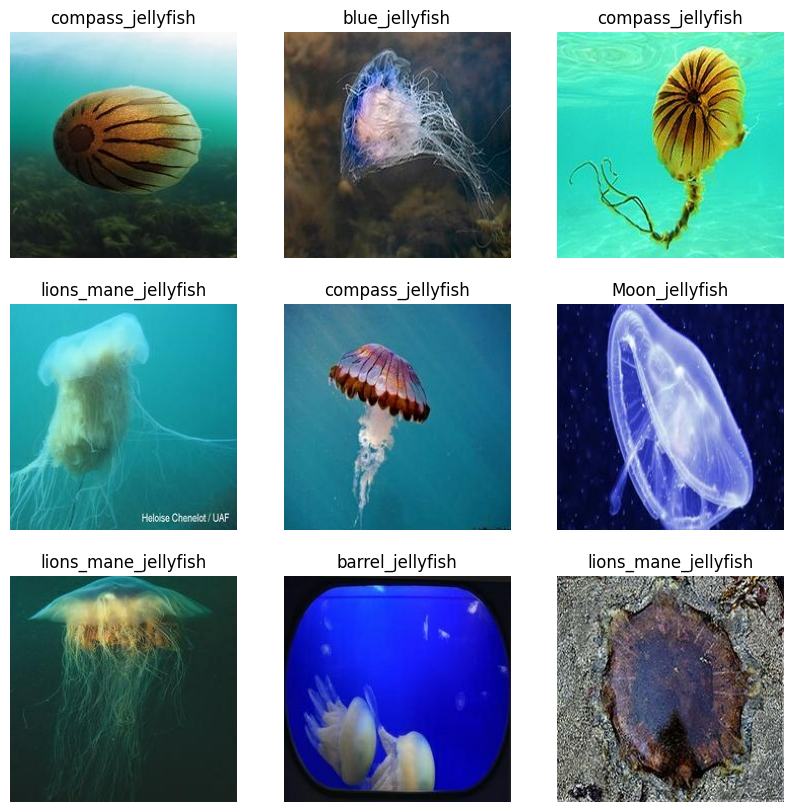

In [ ]:
# 원본 이미지 확인
# 9개의 랜덤 이미지 추출
random_indices = np.random.choice(X_train.shape[0], size=9, replace=False)
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
  ax.imshow(X_train[random_indices[i]])
  ax.set_title(list(class_dict.keys())[y_train[random_indices[i]]])
  ax.axis('off')
plt.show()

### 증강

Generate pipeline

In [ ]:
# 증강 파이프라인 생성
augmentation_transforms = AugmentationManager.create_train_augmentation(
    rotation_range=20,          # -40도 +40도 사이에서 무작위 회전
    width_shift_range=0.1,      # 이미지 가로 방향으로 원본 너비의 20%까지 무작위 이동
    height_shift_range=0.1,     # 이미지 세로 방향으로 원본 높이의 20%까지 무작위 이동
    zoom_range=0.2,             # 이미지를 0.8배에서 1.2배 사이로 무작위 확대/축소
    horizontal_flip=True        # 이미지 좌우 반전
    # brightness_range=(0.8, 1.2),
    # contrast_range=(0.8, 1.2)
)

### Confirm

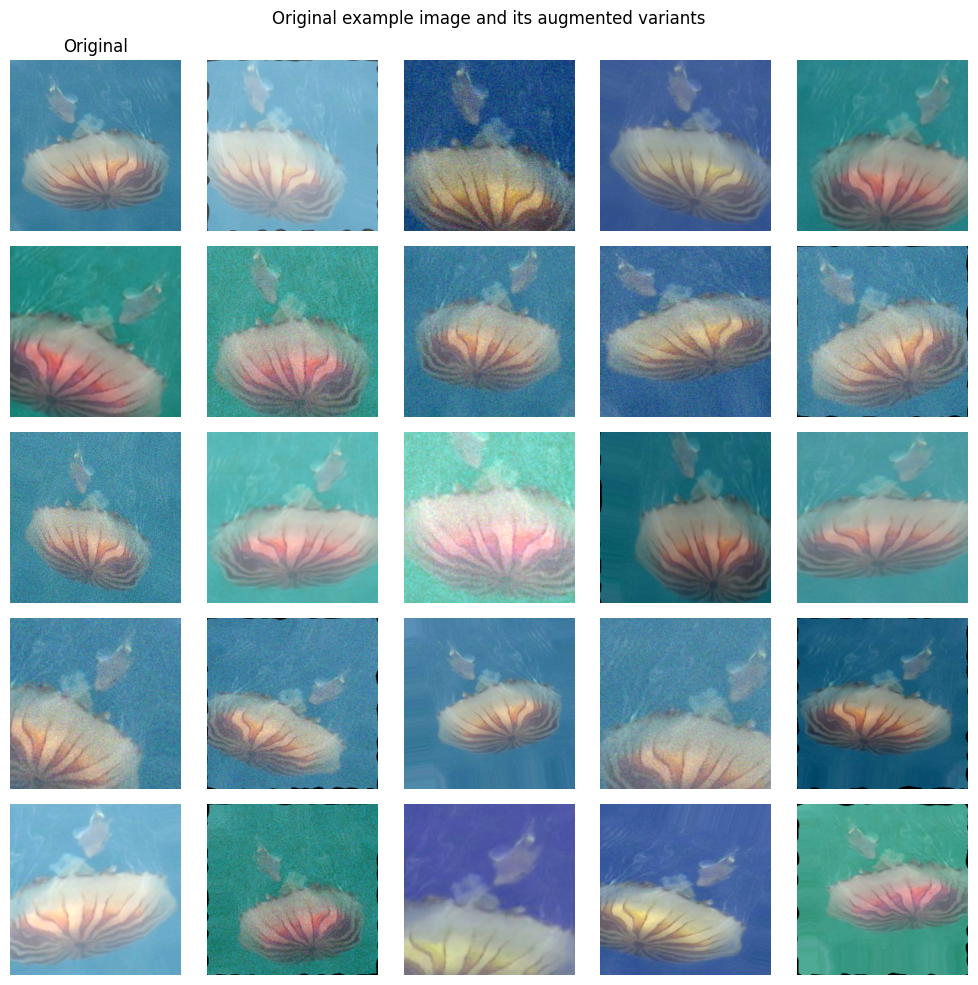

In [ ]:
# 증강 이미지 확인하기
# 랜덤 이미지 선택 및 증강
image = X_train[np.random.randint(len(X_train))]
augs = apply_augmentation(image, augmentation_transforms, num_samples=24)

# 시각화
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle('Original example image and its augmented variants')

for i, ax in enumerate(axes.ravel()):
    ax.axis('off')
    if i == 0:
        # 원본 이미지 표시
        if len(image.shape) == 3 and image.shape[2] == 3:
            ax.imshow(image)  # 컬러 이미지
        else:
            ax.imshow(image, cmap='Greys')  # 흑백 이미지
        ax.set_title('Original')
    elif i-1 < len(augs):
        # 증강된 이미지 표시
        if len(augs[i-1].shape) == 3 and augs[i-1].shape[2] == 3:
            ax.imshow(augs[i-1])  # 컬러 이미지
        else:
            ax.imshow(augs[i-1], cmap='Greys')  # 흑백 이미지

plt.tight_layout()
plt.show()

In [ ]:
def get_class_labels(data_path):
  """
  디렉토리 구조를 기반으로 클래스 레이블 추론

  Args:
    data_path: 클래스 별 하위폴더를 포함하는 데이터셋의 상위 디렉토리

  Returns:
    클래스 레이블을 딕셔너리로 반환
  """
  class_labels = {}
  for folder_name in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder_name)
    if os.path.isdir(folder_path):
      class_labels[folder_name] = folder_name  # Assuming directory name is the class label
  return class_labels

# Get class labels for train and validation sets
train_labels = get_class_labels(choose_train_path)
val_labels = get_class_labels(choose_val_path)

print("Train Labels:", train_labels)
print("Validation Labels:", val_labels)

Train Labels: {'blue_jellyfish': 'blue_jellyfish', 'mauve_stinger_jellyfish': 'mauve_stinger_jellyfish', 'lions_mane_jellyfish': 'lions_mane_jellyfish', 'Moon_jellyfish': 'Moon_jellyfish', 'compass_jellyfish': 'compass_jellyfish', 'barrel_jellyfish': 'barrel_jellyfish'}
Validation Labels: {'mauve_stinger_jellyfish': 'mauve_stinger_jellyfish', 'lions_mane_jellyfish': 'lions_mane_jellyfish', 'Moon_jellyfish': 'Moon_jellyfish', 'barrel_jellyfish': 'barrel_jellyfish', 'blue_jellyfish': 'blue_jellyfish', 'compass_jellyfish': 'compass_jellyfish'}


## 분류기 초기 설정 진행

In [ ]:

def normalization_layer(input_tensor):
    """
    Normalizes the input tensor using BatchNormalization.

    Args:
        input_tensor: The input tensor to normalize.

    Returns:
        The normalized tensor.
    """
    return layers.BatchNormalization()(input_tensor)

"""
원규님 model option
model = vgg16
learning_rate: 0.001
batch_size = 16
epochs = 15
optimizer = adam

"""
def get_vgg_model():
    return JellyfishClassifier(
        num_classes=6,
        model_type='vgg',
        pretrained=True,
        metrics=['accuracy', 'f1_score'],
        learning_rate= 0.001 #1e-3
    )

def get_resnet_model():
    return JellyfishClassifier(
        num_classes=6,
        model_type='vgg',
        pretrained=True,
        metrics=['accuracy', 'f1_score'],
        learning_rate= 0.001 #1e-3
    )

# 1. 분류기 초기화
# classifier = get_vgg_model()



classifier = JellyfishClassifier(
    num_classes=6,  # 해파리 클래스 수
    model_type='efficientnet',  # 'efficientnet', 'mobilenet', 'resnet','vgg' 중 선택
    pretrained=True,  # ImageNet 가중치 사용
    metrics=['accuracy', 'f1_score'],  # 평가 지표에서 entropy 제거 -> evaluate 에서 계산
    # learning_rate=1e-5  # 학습률 조정
)

# 2. 분류기 인스턴스에서 모델 서머리 출력:
classifier.model.summary()




58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 7, 7, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_9           │ (None, 512)                 │              

 Total params: 14,849,606 (56.65 MB)

 Trainable params: 14,848,582 (56.64 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
# 3. 모델 훈련
# JellyfishClassifier 클래스 내부의 fit 메서드에서 TTA 자동 적용
classifier.fit(
    (X_train, y_train),  # 또는 train_generator
    validation_data=(X_valid, y_valid),  # 또는 val_generator
    epochs=15,
    batch_size=16
)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.1548 - loss: 1.8112
Epoch 1: val_loss improved from inf to 47.62938, saving model to best_jellyfish_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.1554 - loss: 1.8106 - val_accuracy: 0.1695 - val_loss: 47.6294
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.2537 - loss: 1.7540
Epoch 2: val_loss improved from 47.62938 to 32.93656, saving model to best_jellyfish_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 304ms/step - accuracy: 0.2540 - loss: 1.7529 - val_accuracy: 0.1695 - val_loss: 32.9366
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.2959 - loss: 1.6899
Epoch 3: val_loss improved from 32.93656 to 15.18993, saving model to best_jellyfish_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 303ms/step - accuracy: 0.2958 - loss: 1.6896 - val_accuracy: 0.1695 - val_loss: 15.1899
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.2765 - loss: 1.6700
Epoch 4: val_loss improved from 15.18993 to 11.18550, saving model to best_jellyfish_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 320ms/step - accuracy: 0.2769 - loss: 1.6694 - val_accuracy: 0.1695 - val_loss: 11.1855
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.2800 - loss: 1.7258
Epoch 5: val_loss improved from 11.18550 to 10.88907, saving model to best_jellyfish_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 319ms/step - accuracy: 0.2798 - loss: 1.7241 - val_accuracy: 0.1695 - val_loss: 10.8891
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.3331 - loss: 1.6153
Epoch 6: val_loss improved from 10.88907 to 8.22584, saving model to best_jellyfish_model.h5


29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 305ms/step - accuracy: 0.3334 - loss: 1.6156 - val_accuracy: 0.1695 - val_loss: 8.2258
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.3544 - loss: 1.6138
Epoch 7: val_loss did not improve from 8.22584
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - accuracy: 0.3526 - loss: 1.6151 - val_accuracy: 0.1695 - val_loss: 13.3307
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.3244 - loss: 1.6101
Epoch 8: val_loss did not improve from 8.22584
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 294ms/step - accuracy: 0.3240 - loss: 1.6108 - val_accuracy: 0.1695 - val_loss: 11.3046
Epoch 9/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.3122 - loss: 1.6354
Epoch 9: val_loss did not improve from 8.22584
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 290ms/step - accuracy: 0.3122 - loss: 1.6355 - val_accuracy: 0.1695 - val_loss: 20.3495
Epoch 10/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.3662 - loss: 1.5888
Epoch 10: val_loss did not improve from 8.2

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 310ms/step - accuracy: 0.3001 - loss: 1.5917 - val_accuracy: 0.1695 - val_loss: 7.7191
Epoch 12/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.3188 - loss: 1.6130
Epoch 12: val_loss did not improve from 7.71914
29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 297ms/step - accuracy: 0.3195 - loss: 1.6121 - val_accuracy: 0.1695 - val_loss: 22.9272
Epoch 13/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.2940 - loss: 1.6713
Epoch 13: val_loss did not improve from 7.71914
29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 396ms/step - accuracy: 0.2945 - loss: 1.6699 - val_accuracy: 0.1695 - val_loss: 18.2109
Epoch 14/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.3270 - loss: 1.6026
Epoch 14: val_loss did not improve from 7.71914
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 327ms/step - accuracy: 0.3262 - loss: 1.6028 - val_accuracy: 0.1695 - val_loss: 9.1335
Epoch 15/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.3472 - loss: 1.5348
Epoch 15: val_loss improved from 7.7

29/29 ━━━━━━━━━━━━━━━━━━━━ 9s 314ms/step - accuracy: 0.3458 - loss: 1.5375 - val_accuracy: 0.1695 - val_loss: 4.7394


## 훈련 검증 및 시각화

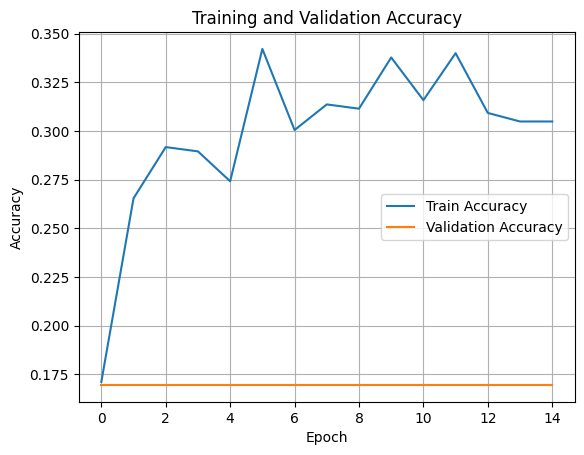

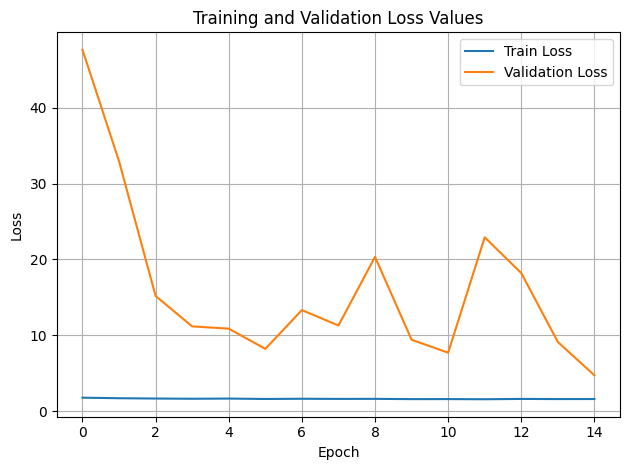

In [ ]:
# 훈련 검증 시각화
# classifier 객체가 검증 지표를 담은 history 를 가지고 있음
history = classifier.history

fig, ax = plt.subplots()
ax.set(title='Training and Validation Accuracy', xlabel='Epoch', ylabel='Accuracy')
ax.grid()
ax.plot(history.history['accuracy'], label='Train Accuracy')
ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax.legend()

fig, ax = plt.subplots()
ax.set(title='Training and Validation Loss Values', xlabel='Epoch', ylabel='Loss')
ax.grid()
ax.plot(history.history['loss'], label='Train Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.legend()

plt.tight_layout()
plt.show()

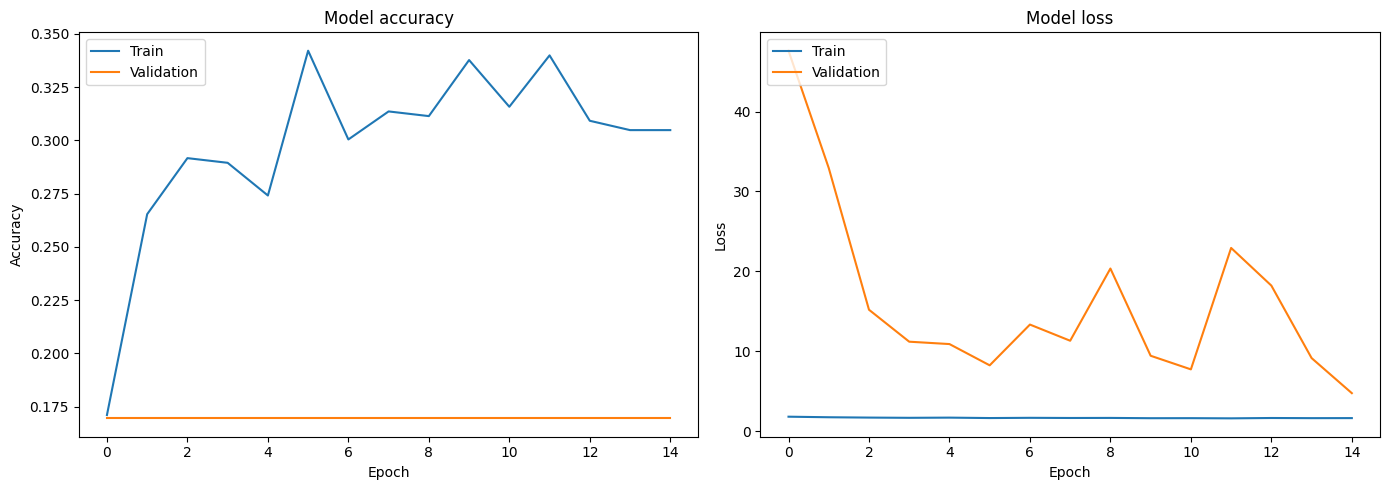

In [ ]:
# 'classifier' 객체가 학습 지표를 포함한 history 속성을 가지고 있다고 가정
history = classifier.history

# 학습 및 검증 정확도(accuracy) 그래프 그리기
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])  # history.history를 사용해 학습 정확도에 접근
plt.plot(history.history['val_accuracy']) # history.history를 사용해 검증 정확도에 접근
plt.title('Model accuracy')# 그래프 제목 설정
plt.ylabel('Accuracy')  # y축 레이블 설정
plt.xlabel('Epoch') # x축 레이블 설정
plt.legend(['Train', 'Validation'], loc='upper left') # 범례 추가

# 학습 및 검증 손실(loss) 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(history.history['loss']) # history.history를 사용해 학습 손실에 접근
plt.plot(history.history['val_loss']) # history.history를 사용해 검증 손실에 접근
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout() # 그래프 간격 조정
plt.show() # 그래프 출력

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow(
    X_train, batch_size=8, shuffle=False
)
y_pred_proba = classifier.model.predict(test_generator)

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step


In [ ]:
y_pred_proba

array([[7.5642240e-01, 1.3441943e-02, 1.1979673e-06, 2.0389023e-01,
        3.4136709e-03, 2.2830609e-02],
       [7.5715911e-01, 1.3329870e-02, 1.1572148e-06, 2.0344782e-01,
        3.3620475e-03, 2.2700042e-02],
       [7.5666404e-01, 1.3404535e-02, 1.1843345e-06, 2.0374672e-01,
        3.3960745e-03, 2.2787515e-02],
       ...,
       [7.5684863e-01, 1.3370917e-02, 1.1714521e-06, 2.0364803e-01,
        3.3816902e-03, 2.2749685e-02],
       [7.5768733e-01, 1.3249166e-02, 1.1292856e-06, 2.0312980e-01,
        3.3249368e-03, 2.2607682e-02],
       [7.5717831e-01, 1.3325136e-02, 1.1555040e-06, 2.0344038e-01,
        3.3600207e-03, 2.2695048e-02]], dtype=float32)

In [ ]:
classifier.predict(X_train)

15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.metrics import log_loss, f1_score, classification_report

y_pred_proba = classifier.predict(val_generator)
y_pred = np.argmax(y_pred_proba, axis=1)

def calculate_entropy(probabilities):
    return -np.sum(probabilities * np.log(probabilities + 1e-10), axis=1)

# 엔트로피 값 계산
entropy_values = calculate_entropy(y_pred_proba)

# 엔트로피의 평균값 출력
mean_entropy = np.mean(entropy_values)
print(f"Mean Entropy: {mean_entropy}")

# F1 스코어 계산
# y_true는 실제 레이블을 가져와야 합니다. 예시로 사용합니다.
y_true = val_generator.classes  # 실제 클래스 레이블
f1 = f1_score(y_true, y_pred, average='weighted')  # 가중 평균 F1 스코어
print(f"F1 Score: {f1}")

# F1 스코어에 대한 분류 보고서 출력
print(classification_report(y_true, y_pred))

# 추가: 엔트로피의 분포 시각화
plt.hist(entropy_values, bins=20)
plt.title('Entropy Distribution')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.show()

NameError: name 'classifier' is not defined

In [ ]:
# 사용 예시
"""
# 1. 분류기 초기화
classifier = JellyfishClassifier(
    num_classes=5,  # 해파리 클래스 수
    model_type='efficientnet',  # 'efficientnet', 'mobilenet', 'resnet' 중 선택
    pretrained=True,  # ImageNet 가중치 사용
    metrics=['accuracy', 'f1_score', 'entropy'],  # 평가 지표
    learning_rate=0.001
)

# 2. 데이터 준비 (예시)
# NumPy 배열로부터 직접 로드
X_train, y_train = load_jellyfish_data('train')  # 데이터 로드 함수 (직접 구현 필요)
X_val, y_val = load_jellyfish_data('val')
X_test, y_test = load_jellyfish_data('test')

# 또는 디렉토리에서 로드
train_datagen = classifier.create_train_augmentation()
train_generator = train_datagen.flow_from_directory(
    'data/jellyfish/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    'data/jellyfish/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

# 3. 모델 훈련
classifier.fit(
    (X_train, y_train),  # 또는 train_generator
    validation_data=(X_val, y_val),  # 또는 val_generator
    epochs=20,
    batch_size=32
)

# 4. 모델 평가 (TTA 적용)
results = classifier.evaluate(
    (X_test, y_test),
    use_tta=True,
    n_augmentations=3
)
print(f"Test results: {results}")

# 5. K-fold 교차 검증
kfold_results = classifier.k_fold_cross_validation(
    X_train, y_train, n_splits=5, epochs=10
)
print(f"K-fold results: {kfold_results}")

# 6. 시각화
classifier.plot_confusion_matrix(class_names=['종류1', '종류2', '종류3', '종류4', '종류5'])
classifier.plot_training_history()

# 7. 모델 저장 및 로드
classifier.save_model('jellyfish_classifier.keras')
classifier.load_model('jellyfish_classifier.keras')

# 8. 새 이미지 예측 (TTA 적용)
new_images = load_new_images()  # 새 이미지 로드
predictions = classifier.predict(new_images, use_tta=True)
print(f"Predictions: {predictions}")
"""